In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
from IPython.display import HTML

In [2]:
import sys

sys.path.append("..")
from experanto.interpolators import SequenceInterpolator, PhaseShiftedSequenceInterpolator, ScreenInterpolator

import numpy as np

#### Test the screeninterpolator for video stimuli data

In [ ]:
video_interpolator = ScreenInterpolator(
    "/data/dynamic27204-5-13-Video-021a75e56847d574b9acbcc06c675055_30hz/screen"
)

In [4]:
n = 1000
times = np.arange(video_interpolator.start_time+500, video_interpolator.start_time+500+n, 20)
time_steps = len(times)
video, valid = video_interpolator.interpolate(times)

%timeit signal, valid = video_interpolator.interpolate(times)

18 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Visualize the video

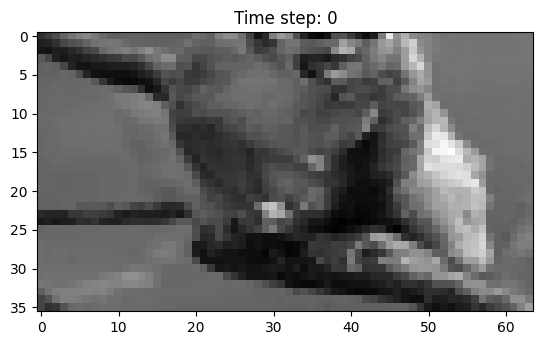

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(video[0], cmap="gray")


def update(frame):
    im.set_data(video[frame])
    ax.set_title(f"Time step: {frame}")
    return [im]


ani = animation.FuncAnimation(fig, update, frames=range(time_steps), repeat=False)
HTML(ani.to_jshtml())

#### Test the sequence interpolator on eye tracking data

In [ ]:
si = SequenceInterpolator(
    "/data/dynamic27204-5-13-Video-021a75e56847d574b9acbcc06c675055_30hz/eye_tracker"
    )

Load 1000 timestamps that should return the first 1000 samples and time it. 

In [7]:
n = 1000
times = np.arange(
    si.start_time + si.time_delta * 0.3,
    n * si.time_delta + si.start_time,
    si.time_delta,
)
%timeit signal, valid = si.interpolate(times)

21.5 μs ± 62.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Make sure the correct samples are returned.  

But first find the starting index of non-NaN values.

In [8]:
# get the idx of first non-NaN value
idx = np.where(~np.isnan(si._data))[0][0] 
idx

np.int64(184)

In [9]:
correct_start = si.time_delta * (idx+1) + si.start_time

n = 100
times = np.arange(
    correct_start, #+ si.time_delta * 0.3,
    n * si.time_delta + correct_start,
    si.time_delta,
)

signal, valid = si.interpolate(times)

assert np.nanmin(np.abs(si._data[idx+1:idx+n+1] - signal)) < 1e-6

Make sure that it also returns the correct valid index and shape

In [10]:
n = 10
times = np.arange(
    si.start_time - si.time_delta * 0.7,
    n * si.time_delta + si.start_time,
    si.time_delta,
)
signal, valid = si.interpolate(times)
valid, valid.shape, signal.shape

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), (10,), (10, 4))

#### Check interpolator for neuron sequences

For neuronal responses we use PhaseShiftedSequenceInterpolator

In [ ]:
neural_responses = PhaseShiftedSequenceInterpolator(
    "/data/dynamic27204-5-13-Video-021a75e56847d574b9acbcc06c675055_30hz/responses"
)

***_phase_shifts*** accounts for small time delays between neuronal responses. For example, in imaging experiments neuronal responses are acquired sequentially, i.e. with a time delay of microscope refocusing from one neuron to another.  
in this case we have 7538 neurons

In [12]:
neural_responses._data.shape, neural_responses._phase_shifts.shape

((224314, 7538), (7538,))

In the following **.interpolate** only returns valid within the ***neural_responses.valid_interval*** time indices 

In [13]:
n = 10
times = np.arange(
    neural_responses.start_time + neural_responses.time_delta * 0.0,
    n * neural_responses.time_delta + neural_responses.start_time,
    neural_responses.time_delta,
)
signal, valid = neural_responses.interpolate(times)
valid, valid.shape, signal.shape

(array([4, 5, 6, 7, 8, 9]), (6,), (6, 7538))

maximal phase shift between neurons

In [14]:
np.max(neural_responses._phase_shifts)

np.float64(0.114)